In [50]:
!pip install datasets pandas matplotlib seqeval -q


In [51]:
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import json 
from datasets import load_dataset
import seqeval
from seqeval.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score      
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')


In [52]:
save_root = 'local/img/'


# Parsing des fichiers

Dans le serveur, localiser le fichier à copier (en général, dans les checkpoints) qui s'appelle `trainer_state.json`. Le copier avec `scp`. Voici un exemple de syntaxe. 

```{bash}
rsync -av --exclude '*.safetensors' --exclude '*.bin' --exclude '*.pt' --exclude '*.pth' au78760@ens.ad.etsmtl.ca@logti-hyper-c1.ens.ad.etsmtl.ca:~/mti881-projet2/checkpoints/ ./local/
scp au78760@ens.ad.etsmtl.ca@logti-hyper-c1.ens.ad.etsmtl.ca:~/mti881-projet2/checkpoints/model.safetensors ./local/
```

In [53]:
trainer_state_file = 'local1/trainer_state.json'

# Load the trainer state
try :
    with open(trainer_state_file, 'r') as f:
        log = json.load(f)
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
    log = None
except FileNotFoundError as e:
    print(f"File not found: {e}")
    log = None
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    log = None

In [54]:
all_results_file = 'local1/all_results.json'
# Load the all_results.json file
try:
    with open(all_results_file, 'r') as f:
        all_results = json.load(f)
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
    all_results = None
except FileNotFoundError as e:
    print(f"File not found: {e}")
    all_results = None
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    all_results = None
# all_results.keys()

# Analyse des données d'entraînement (TRAIN-VAL)

## Métriques globales

In [55]:
def extract_global_metrics(log):
    """
    Extracts global metrics from the trainer state log.
    """
    global_metrics_val = []
    global_metric_train = []
    keys_val = [
        'eval_loss', 'eval_overall_accuracy', 'eval_overall_f1', 
        'eval_overall_precision', 'eval_overall_recall', 'step'
    ] 
    keys_train = [
        "epoch", "grad_norm", "learning_rate", "loss", "step"
    ]
    for entry in log['log_history']:
        # Validation metrics
        keys, values = entry.keys(), entry.values()
        if all(key in keys for key in keys_val):
            metrics = {key: value for key, value in zip(keys, values) if key in keys_val}
            global_metrics_val.append(metrics)

        # Training metrics
        if all(key in keys for key in keys_train):
            metrics = {key: value for key, value in zip(keys, values) if key in keys_train}
            global_metric_train.append(metrics)
    
    # Convert to DataFrame for easier manipulation
    df_train = pd.DataFrame(global_metric_train)
    df_val = pd.DataFrame(global_metrics_val)
    # Concatenate the DataFrames
    df = df_train.join(df_val, rsuffix='_val')
    # Choose epoch and step as first columns

    cols = df.columns.tolist()
    cols = ["epoch", "step", "step_val"] + [col for col in cols if col not in ["epoch", "step", "step_val"]]
    df = df[cols]
    return df


df_global = extract_global_metrics(log)
df_global.head()

,epoch,step,step_val,grad_norm,learning_rate,loss,eval_loss,eval_overall_accuracy,eval_overall_f1,eval_overall_precision,eval_overall_recall
0,0.687285,500,500,1.689597,0.000009,0.9164,0.617679,0.823528,0.430392,0.445638,0.416155
1,1.373883,1000,1000,2.096715,0.000009,0.5946,0.535067,0.839851,0.485781,0.493922,0.477904
2,2.060481,1500,1500,2.349780,0.000008,0.5293,0.502425,0.848854,0.522726,0.545506,0.501773
3,2.747766,2000,2000,1.780960,0.000007,0.4849,0.480432,0.852749,0.536257,0.538502,0.534031
4,3.434364,2500,2500,1.558536,0.000007,0.4566,0.472066,0.855029,0.549208,0.540783,0.557900


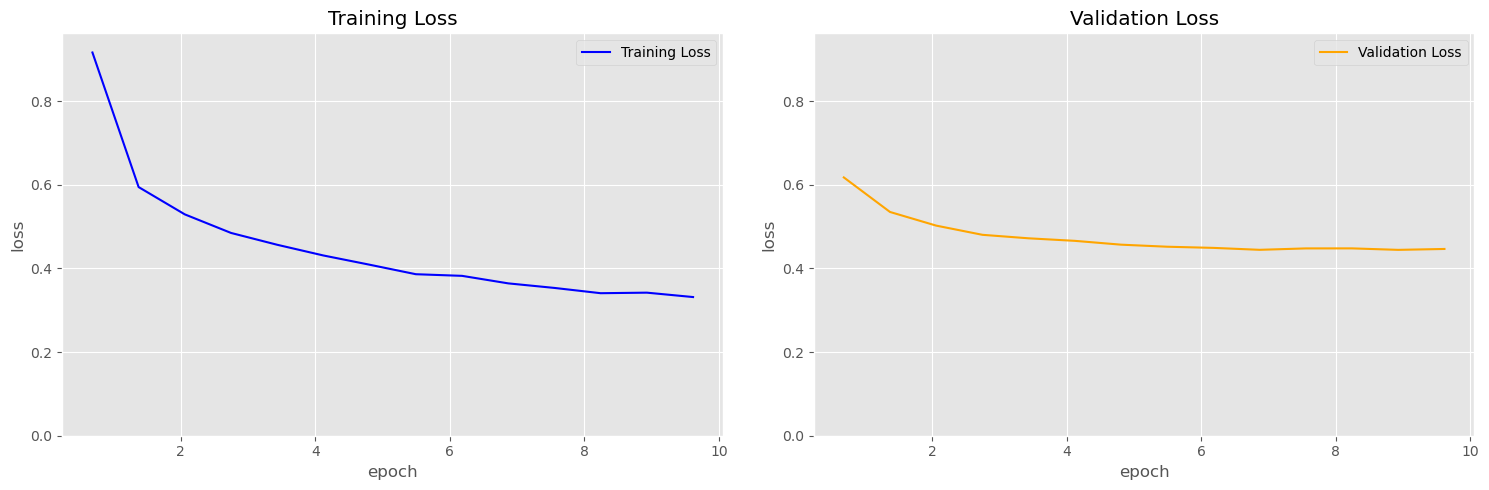

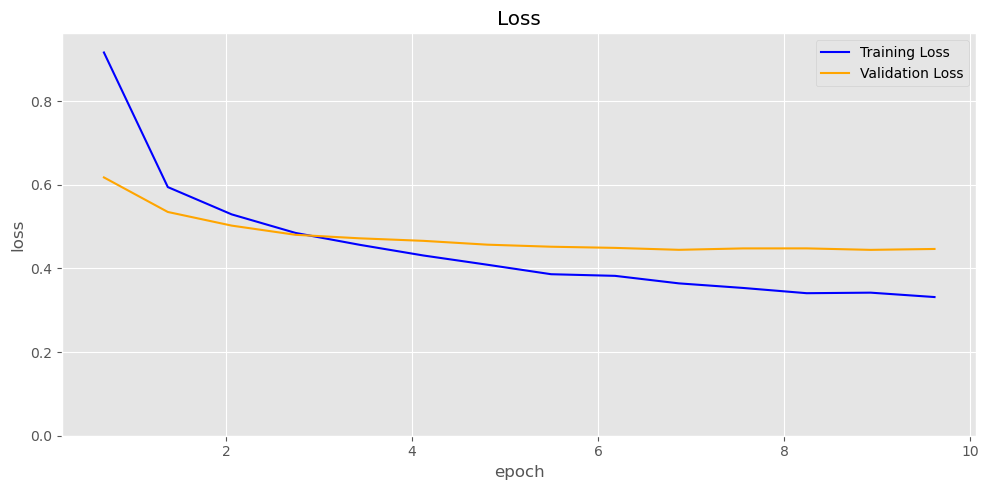

In [56]:

def plot_loss(df_global, x_axis='epoch'):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    max_loss = max(df_global['loss'].max(), df_global['eval_loss'].max()) * 1.05


    # Training loss
    ax[0].plot(df_global[x_axis], df_global['loss'], label='Training Loss', color='blue')
    ax[0].set_title('Training Loss')
    ax[0].set_xlabel(x_axis)
    ax[0].set_ylabel('loss')
    ax[0].legend()
    # ax[0].grid()
    # Validation loss
    ax[1].plot(df_global[x_axis], df_global['eval_loss'], label='Validation Loss', color='orange')
    ax[1].set_title('Validation Loss')
    ax[1].set_xlabel(x_axis)
    ax[1].set_ylabel('loss')
    ax[1].legend()
    # ax[1].grid()
    plt.tight_layout()
    ax[0].set_ylim(0, max_loss)
    ax[1].set_ylim(0, max_loss)
    plt.show()
    return fig, ax

def plot_loss_same_fig(df_global, x_axis='epoch'):
    fig, ax = plt.subplots(figsize=(10, 5))
    max_loss = max(df_global['loss'].max(), df_global['eval_loss'].max()) * 1.05

    # Training loss
    ax.plot(df_global[x_axis], df_global['loss'], label='Training Loss', color='blue')
    # Validation loss
    ax.plot(df_global[x_axis], df_global['eval_loss'], label='Validation Loss', color='orange')
    ax.set_title('Loss')
    ax.set_xlabel(x_axis)
    ax.set_ylabel('loss')
    ax.legend()
    
    plt.tight_layout()
    ax.set_ylim(0, max_loss)
    plt.show()
    return fig, ax

fig, ax = plot_loss(df_global)
fig.savefig(f'{save_root}/loss.png', dpi=300, bbox_inches='tight')
fig, ax = plot_loss_same_fig(df_global)
fig.savefig(f'{save_root}/loss_same_fig.png', dpi=300, bbox_inches='tight')


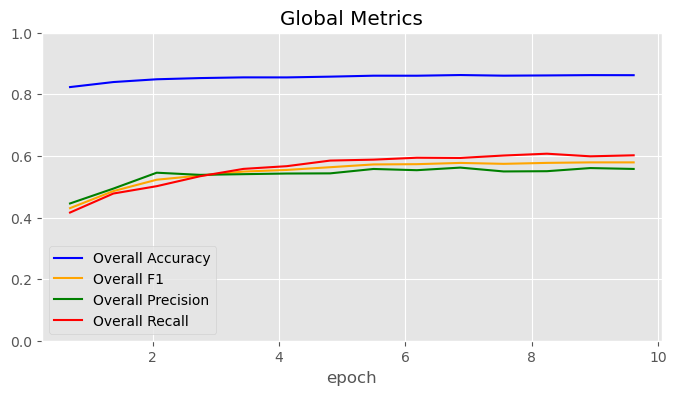

In [57]:
def plot_global_metrics(df_global, x_axis='epoch'):
    
    fig, ax = plt.subplots(figsize=(8, 4))
    metric_name = ['eval_overall_accuracy', 'eval_overall_f1', 'eval_overall_precision', 'eval_overall_recall']
    metric_label = ['Overall Accuracy', 'Overall F1', 'Overall Precision', 'Overall Recall']
    colors = ['blue', 'orange', 'green', 'red']
    for i, metric in enumerate(metric_name):
        ax.plot(df_global[x_axis], df_global[metric], label=metric_label[i], color=colors[i])
    ax.set_title('Global Metrics')
    ax.set_xlabel(x_axis)
    plt.ylim(0, 1)
    ax.legend()
    # ax.grid()
    plt.show()
    return fig, ax

    # Overall accuracy
fig, ax = plot_global_metrics(df_global)
fig.savefig(f'{save_root}/global_metrics.png', dpi=300, bbox_inches='tight')

In [58]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

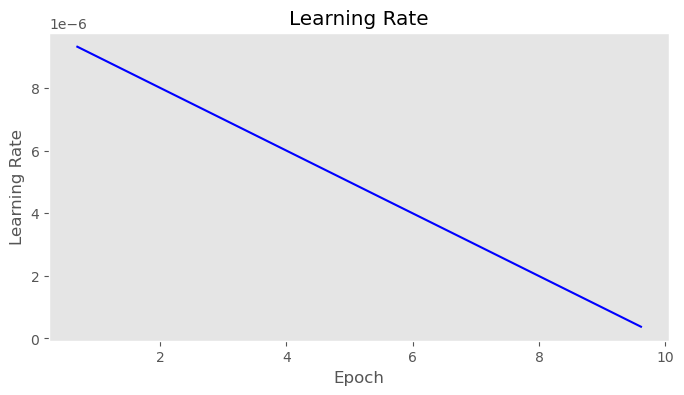

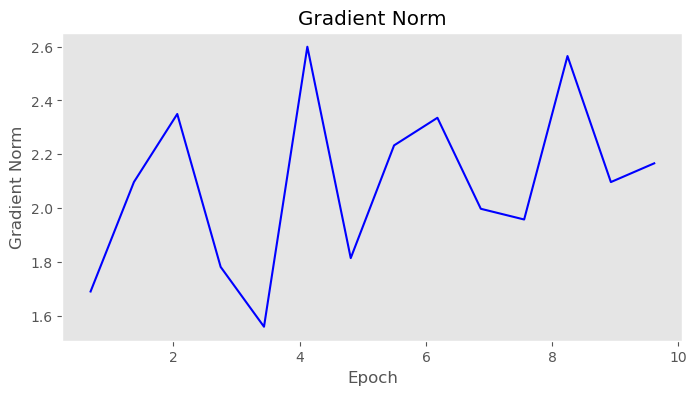

In [59]:
def plot_grad_norm(df_global):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(df_global['epoch'], df_global['grad_norm'], label='Gradient Norm', color='blue')
    ax.set_title('Gradient Norm')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Gradient Norm')
    # ax.legend()
    ax.grid()
    plt.show()
    return fig, ax
def plot_learning_rate(df_global):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(df_global['epoch'], df_global['learning_rate'], label='Learning Rate', color='blue')
    ax.set_title('Learning Rate')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Learning Rate')
    # ax.legend()
    ax.grid()
    plt.show()
    return fig, ax
fig, ax = plot_learning_rate(df_global)
fig.savefig(f'{save_root}/learning_rate.png', dpi=300, bbox_inches='tight')
fig, ax = plot_grad_norm(df_global)
fig.savefig(f'{save_root}/grad_norm.png', dpi=300, bbox_inches='tight')

## Métriques de test (comparaison avec les métriques de validation de la dernière epoch)

In [60]:
def extract_eval_predictions(all_results):
    """
    Extracts evaluation predictions from the all_results log.
    """
    # print(all_results.keys())
    eval_keys = [keys for keys in all_results.keys() if 'eval_T' in keys]
    # print(eval_keys)
    pred_keys = [keys for keys in all_results.keys() if 'predict_T' in keys]
    # print(pred_keys)
    # Exctract the classes eval_CLASS_metric
    classes = [key.split('_')[1] for key in eval_keys]
    classes = sorted(set(classes))
    # classes2 = [key.split('_')[1] for key in pred_keys]
    # classes2 = sorted(set(classes2))
    # assert classes == classes2, f"Classes do not match: {classes} vs {classes2}" #OK 
    metrics = [key.split('_')[2] for key in eval_keys]
    metrics = sorted(set(metrics))

    # create a dataframe for the eval metrics
    items = []
    for key in eval_keys:
        class_name = key.split('_')[1]
        metric_name = key.split('_')[2]
        value = all_results[key]
        items.append((class_name, metric_name, value))
    df_eval = pd.DataFrame(items, columns=['class_name', 'metric_name', 'value'])
    df_eval = df_eval.pivot(index='class_name', columns='metric_name', values='value')

    # create a dataframe for the pred metrics
    items = []
    for key in pred_keys:
        class_name = key.split('_')[1]
        metric_name = key.split('_')[2]
        value = all_results[key]
        items.append((class_name, metric_name, value))
    df_pred = pd.DataFrame(items, columns=['class_name', 'metric_name', 'value'])
    df_pred = df_pred.pivot(index='class_name', columns='metric_name', values='value')
    return df_eval, df_pred


df_eval, df_pred = extract_eval_predictions(all_results)
df_eval.head(), df_pred.head()

(metric_name        f1  number  precision    recall
 class_name                                        
 T005         0.285714    25.0   0.500000  0.200000
 T007         0.113208    45.0   0.375000  0.066667
 T017         0.593725  1232.0   0.574355  0.614448
 T022         0.000000     9.0   0.000000  0.000000
 T031         0.000000    22.0   0.000000  0.000000,
 metric_name        f1  number  precision    recall
 class_name                                        
 T005         0.080000    24.0      1.000  0.041667
 T007         0.133333    44.0      0.250  0.090909
 T017         0.605263  1260.0      0.575  0.638889
 T022         0.000000     9.0      0.000  0.000000
 T031         0.000000    20.0      0.000  0.000000)

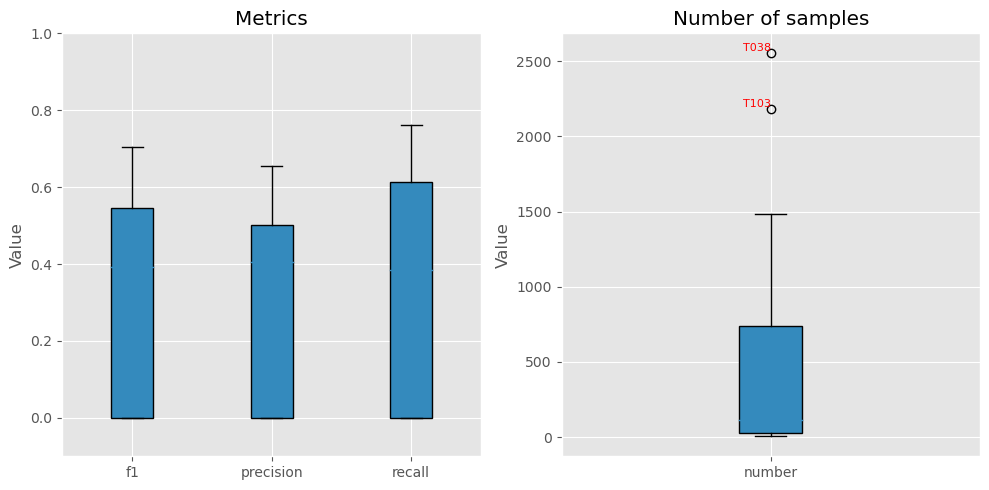

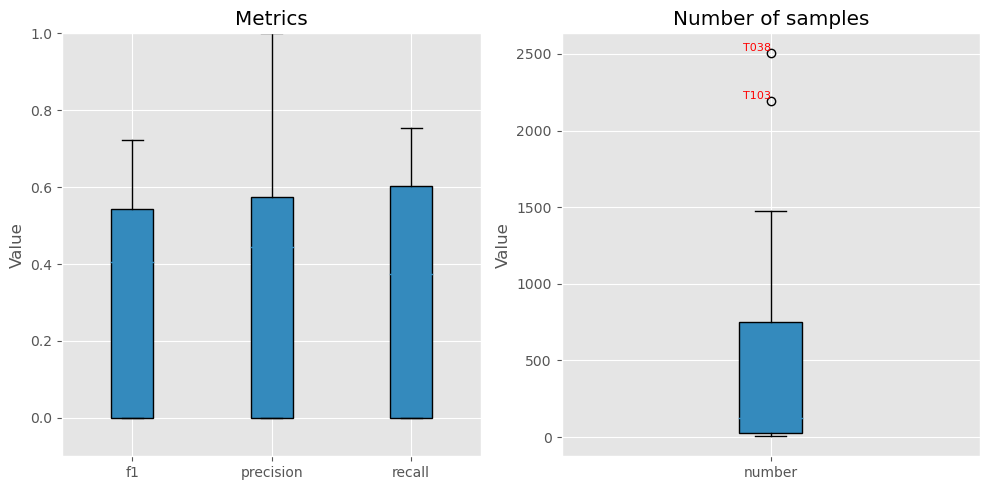

In [61]:

def boxplot_metrics(df):
    """
    Create boxplots for the metrics and number of samples. 
    The function also identifies outliers and annotates them on the plot.

    Parameters:
    df (pd.DataFrame): DataFrame containing the metrics and number of samples.
    """
    df = df.copy().dropna()
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Boxplot for metrics
    metrics = ['f1', 'precision', 'recall']
    box = ax[0].boxplot(df[metrics], labels=metrics, patch_artist=True)
    ax[0].set_title('Metrics')
    ax[0].set_ylabel('Value')
    ax[0].set_ylim(-0.1, 1)

    # Identifier les outliers et les annoter
    for i, metric in enumerate(metrics, start=1):
        q1, q3 = np.percentile(df[metric], [25, 75])
        iqr = q3 - q1
        lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr

        outliers = df[(df[metric] < lower_bound) | (df[metric] > upper_bound)]
        for index, value in outliers[metric].items():
            ax[0].text(i, value, df.index[index], ha='right', va='bottom', fontsize=8, color='red')

    # Boxplot for number of samples
    box = ax[1].boxplot(df['number'], labels=['number'], patch_artist=True)
    ax[1].set_title('Number of samples')
    ax[1].set_ylabel('Value')
    ax[1].set_ylim(-df['number'].max() * 0.05, df['number'].max() * 1.05)

    # Identifier les outliers et les annoter pour 'number'
    q1, q3 = np.percentile(df['number'], [25, 75])
    iqr = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr

    outliers = df[(df['number'] < lower_bound) | (df['number'] > upper_bound)]
    for index, value in outliers['number'].items():
        ax[1].text(1, value, index, ha='right', va='bottom', fontsize=8, color='red')

    plt.tight_layout()
    return fig, ax

# Exemple d'utilisation
fig, ax = boxplot_metrics(df_eval)
fig.savefig(f'{save_root}/boxplot_metrics_eval.png', dpi=300, bbox_inches='tight')
fig, ax = boxplot_metrics(df_pred)
fig.savefig(f'{save_root}/boxplot_metrics_pred.png', dpi=300, bbox_inches='tight')


In [62]:
def get_best_class(df, metric='f1', quantile=None, threshold=None, number=None):
    """
    Get the best class based on the specified metric, quantile, or threshold.
    """
    if quantile is not None:
        # Get the classes above the quantile for the specified metric
        best_classes = df[df[metric] >= df[metric].quantile(quantile)]
    elif threshold is not None:
        # Get the classes above the threshold for the specified metric
        best_classes = df[df[metric] >= threshold]
    elif number is not None:
        # Get the classes with a number of samples above the threshold
        best_classes = df[df['number'] >= number]
    else:
        raise ValueError("Either quantile or seuil must be provided.")
    
    return best_classes

def get_worst_class(df, metric='f1', quantile=None, threshold=None, number=None):
    """
    Get the worst class based on the specified metric, quantile, or threshold.
    """
    if quantile is not None:
        # Get the classes below the quantile for the specified metric
        worst_classes = df[df[metric] <= df[metric].quantile(quantile)]
    elif threshold is not None:
        # Get the classes below the threshold for the specified metric
        worst_classes = df[df[metric] <= threshold]
    elif number is not None:
        # Get the worst number classes 
        worst_classes = df[metric].nsmallest(number)

    else:
        raise ValueError("Either quantile or threshold must be provided.")
    
    return worst_classes
df_best = get_best_class(df_eval, metric='f1', number=10)
df_worst = get_worst_class(df_eval, metric='f1', number=10)

print(len(df_best), len(df_worst))
df_best.head(), df_worst.head(10)



20 10


(metric_name        f1  number  precision    recall
 class_name                                        
 T005         0.285714    25.0   0.500000  0.200000
 T007         0.113208    45.0   0.375000  0.066667
 T017         0.593725  1232.0   0.574355  0.614448
 T031         0.000000    22.0   0.000000  0.000000
 T033         0.393562   988.0   0.404051  0.383603,
 class_name
 T022    0.000000
 T031    0.000000
 T091    0.000000
 T092    0.000000
 T097    0.000000
 T168    0.000000
 T201    0.000000
 T007    0.113208
 T037    0.175439
 T005    0.285714
 Name: f1, dtype: float64)

In [63]:
!pip install adjustText -q

In [68]:
!pip list 

Package                       Version              Editable project location
----------------------------- -------------------- --------------------------------------------------------------------------------------------------
absl-py                       2.1.0
adjustText                    1.3.0
aiohappyeyeballs              2.6.1
aiohttp                       3.11.14
aiosignal                     1.3.2
alabaster                     0.7.12
altgraph                      0.17.3
anaconda-anon-usage           0.4.3
anaconda-client               1.11.0
anaconda-cloud-auth           0.1.4
anaconda-navigator            2.5.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
async-timeout                 5.0.1
atomicwrites                  1.4.0
attrs     

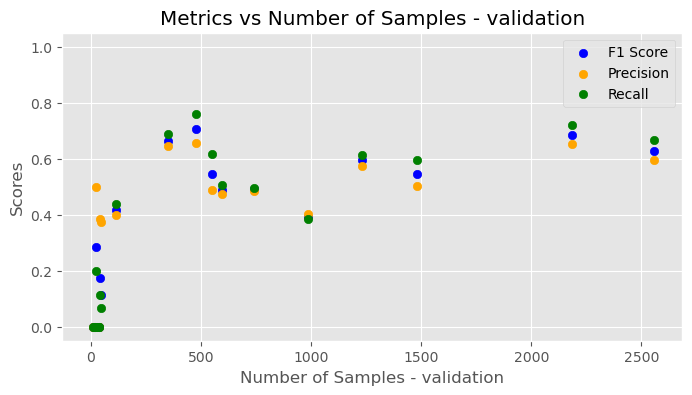

3 [ 0.54978288 -0.51796593]
14 [0.98209665 0.38570818]


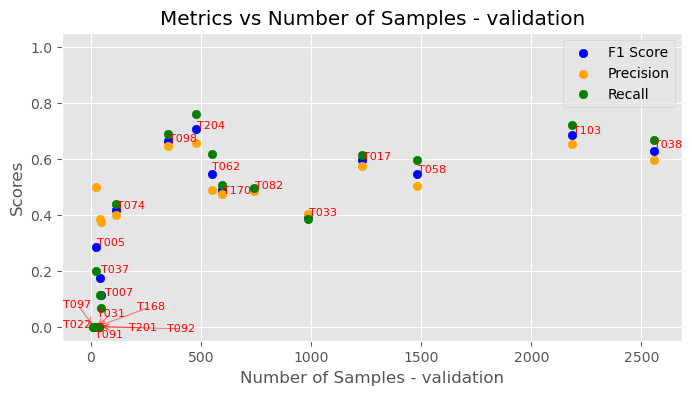

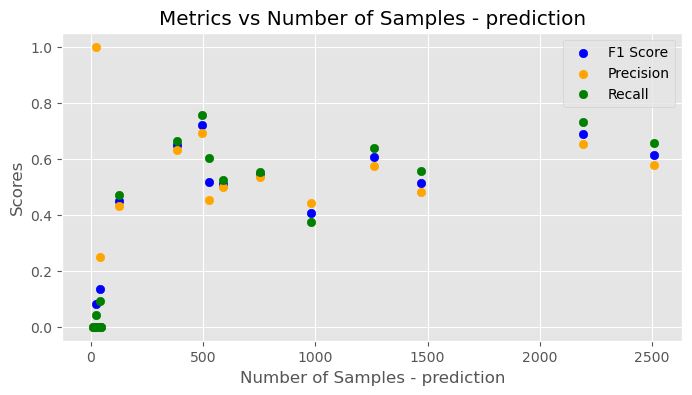

3 [ 0.20138348 -0.83398078]
14 [ 0.33501022 -0.28267213]


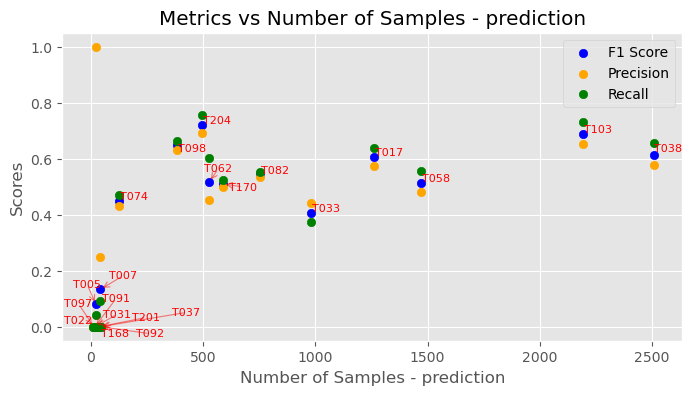

In [64]:
from adjustText import adjust_text
def scatter_plot_metric_support(df, split=None, showLabels=True):
    """
    Create a scatter plot of the metrics against the number of samples.

    Parameters:
    df (pd.DataFrame): DataFrame containing the metrics and number of samples.
    """
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.scatter(df['number'], df['f1'], label='F1 Score', color='blue')
    ax.scatter(df['number'], df['precision'], label='Precision', color='orange')
    ax.scatter(df['number'], df['recall'], label='Recall', color='green')
    ax.set_title('Metrics vs Number of Samples')
    if split is not None:
        ax.set_title(f'Metrics vs Number of Samples - {split}')
        ax.set_xlabel(f'Number of Samples - {split}')
    else :
        ax.set_title('Metrics vs Number of Samples')
        ax.set_xlabel('Number of Samples')
    ax.set_ylabel('Scores')
    plt.ylim(-0.05, 1.05)
    plt.xlim(-df['number'].max() * 0.05, df['number'].max() * 1.05)
    ax.legend()
    if showLabels:
        texts = []
        for i, row in df.iterrows():
            text = ax.text(row['number'], row['f1'], row.name, fontsize=8, color='red')
            texts.append(text)
        adjust_text(
            texts, 
            ax=ax, 
            expand_text=(1.2, 1.5),  # Augmente l'espacement entre les étiquettes
            expand_objects=(1.2, 1.5),  # Évite la superposition avec les points
            force_text=(0.3, 0.5),  # Répartit mieux les étiquettes
            arrowprops=dict(arrowstyle="->", color='red', alpha=0.5, lw=0.8)  # Ajoute des flèches plus visibles
        )
    plt.show()
    return fig, ax
fig, ax = scatter_plot_metric_support(df_eval, split='validation', showLabels=False)
fig.savefig(f'{save_root}/scatter_plot_metric_support_eval_nolabel.png', dpi=300, bbox_inches='tight')
fig, ax = scatter_plot_metric_support(df_eval, split='validation')
fig.savefig(f'{save_root}/scatter_plot_metric_support_eval.png', dpi=300, bbox_inches='tight')
fig, ax = scatter_plot_metric_support(df_pred, split='prediction', showLabels=False)
fig.savefig(f'{save_root}/scatter_plot_metric_support_pred_nolabel.png', dpi=300, bbox_inches='tight')
fig, ax = scatter_plot_metric_support(df_pred, split='prediction')
fig.savefig(f'{save_root}/scatter_plot_metric_support_pred.png', dpi=300, bbox_inches='tight')

# Metric evolution per class

In [65]:
def extract_log_per_class(log):
    log_history = log['log_history']
    # extract the relevant items 
    keys = ['step', 'epoch']
    items = []
    for entry in log_history:
        keys_entry, values_entry = entry.keys(), entry.values()

        if any('eval_T' in key for key in keys_entry):
            keys_to_keep = [key for key in keys_entry if 'eval_T' in key] + keys
            values_to_keep = [value for key, value in zip(keys_entry, values_entry) if 'eval_T' in key] + [entry['step'], entry['epoch']]
            items.append(dict(zip(keys_to_keep, values_to_keep)))
    
    # extract the different classes
    classes = []
    for entry in items :
        for key in entry.keys():
            if 'eval_T' in key and key.split('_')[1] not in classes:
                classes.append(key.split('_')[1])
    classes = sorted(set(classes))
    # print(classes)
    
    # Restructure into a list of dictionaries per class
    result = []
    for class_code in classes:
        class_dict = {
            'class': class_code,
            'epoch': [],
            'step': [],
            'f1': [],
            'precision': [],
            'recall': []
        }
        for entry in items:
            f1_key = f'eval_{class_code}_f1'
            precision_key = f'eval_{class_code}_precision'
            recall_key = f'eval_{class_code}_recall'
            # Check if all required keys are present in the entry
            if f1_key in entry and precision_key in entry and recall_key in entry:
                class_dict['epoch'].append(entry['epoch'])
                class_dict['step'].append(entry['step'])
                class_dict['f1'].append(entry[f1_key])
                class_dict['precision'].append(entry[precision_key])
                class_dict['recall'].append(entry[recall_key])
        result.append(class_dict)
    return result
log_per_class = extract_log_per_class(log)


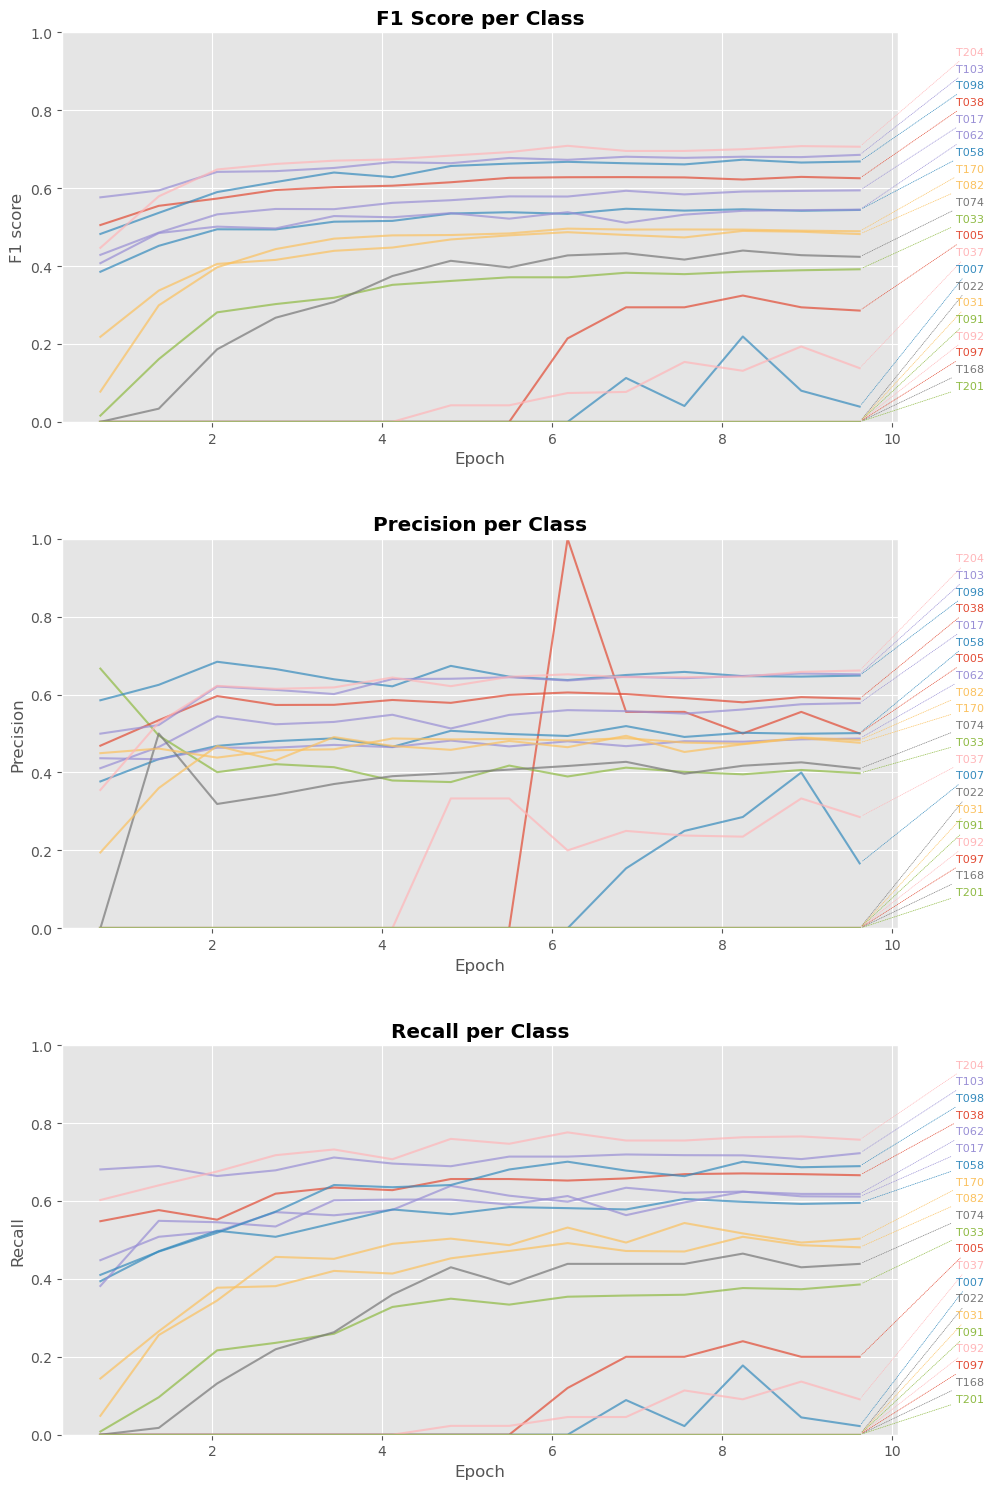

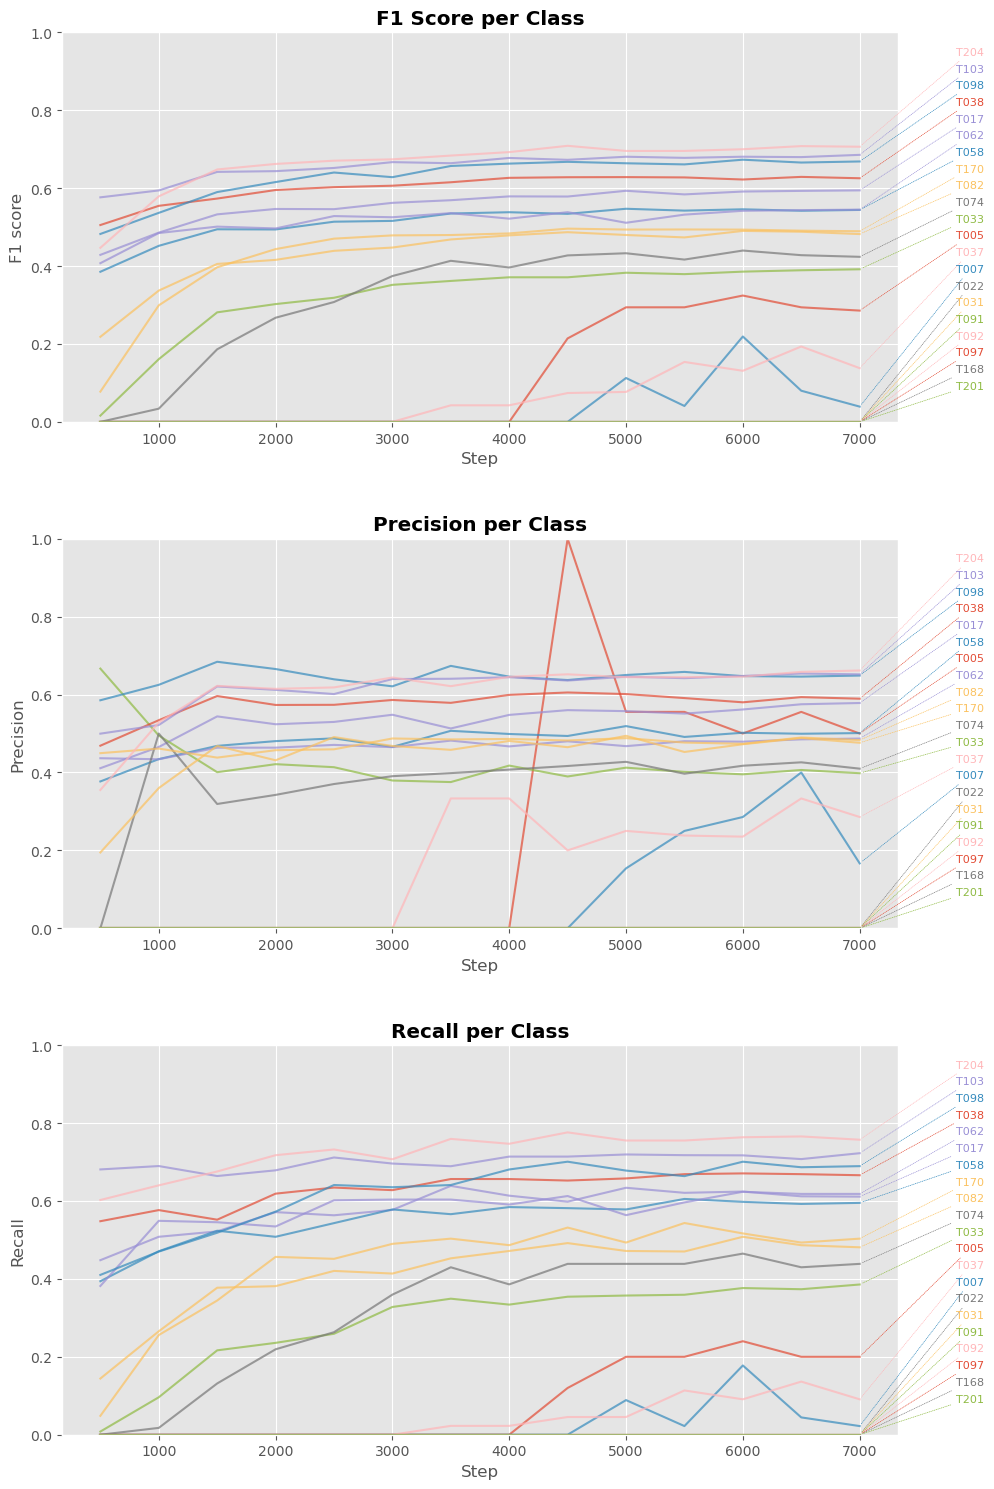

In [66]:
import matplotlib.pyplot as plt

def plot_log_per_class(log_per_class, x_axis='epoch'):
    # Create figure with 3 vertical subplots
    fig, ax = plt.subplots(3, 1, figsize=(10, 15))
    metrics = ['f1', 'precision', 'recall']
    titles = ['F1 Score', 'Precision', 'Recall']
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        class_endpoints = []

        for class_log in log_per_class:
            # Plot the actual data
            line = ax[idx].plot(
                class_log[x_axis], 
                class_log[metric],
                alpha=0.7,
                linewidth=1.5,
                label=class_log['class']
            )
            
            # Collect last point and color for annotation
            last_x = class_log[x_axis][-1]
            last_y = class_log[metric][-1]
            class_endpoints.append({
                'class': class_log['class'],
                'x': last_x,
                'y': last_y,
                'color': line[0].get_color()
            })

        # Sort by y-value descending (top to bottom)
        class_endpoints.sort(key=lambda item: -item['y'])

        # Define vertical spacing between labels
        y_positions = []
        ax[idx].set_xlim(auto=True)  # Ensure xlim is computed
        x_min, x_max = ax[idx].get_xlim()
        x_offset = 0.07 * (x_max - x_min)
        label_x = x_max + x_offset        

        spacing = 1 / len(class_endpoints) * 0.9  # Adjusted for better spacing
        base_y = 0.95
        for i, item in enumerate(class_endpoints):
            y = base_y - i * spacing
            y_positions.append(y)
            ax[idx].annotate(
                item['class'],
                xy=(item['x'], item['y']),
                xytext=(label_x, y),
                textcoords='data',
                color=item['color'],
                fontsize=8,
                va='center',
                arrowprops=dict(
                    arrowstyle='-',
                    color=item['color'],
                    lw=0.5,
                    linestyle='dotted'  # Make arrow dotted
                )
            )

        # Configure subplot appearance
        ax[idx].set_title(f'{title} per Class', fontweight='bold')
        ax[idx].set_xlabel(x_axis.capitalize())
        ax[idx].set_ylabel(title.capitalize())
        ax[idx].set_ylim(0, 1)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    plt.show()
    return fig, ax
fig, ax = plot_log_per_class(log_per_class, x_axis='epoch')
fig.savefig(f'{save_root}/log_per_class_epoch.png', dpi=300, bbox_inches='tight')
fig, ax = plot_log_per_class(log_per_class, x_axis='step')
fig.savefig(f'{save_root}/log_per_class_step.png', dpi=300, bbox_inches='tight')